<a href="https://colab.research.google.com/github/Jaskaran23/CNN/blob/main/Hot_Dog_or_Not_Hot_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hot Dog or Not Hot Dog - Convolutional Neural Network


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

In [ ]:
# Loading Data, here Hot dog is label 55

In [ ]:
ds,ds_info = tfds.load('food101',shuffle_files=True, as_supervised = True, with_info = True)

In [ ]:
#this datset already comes with train and validation dataset split up
train_ds,validate_ds = ds["train"],ds["validation"]

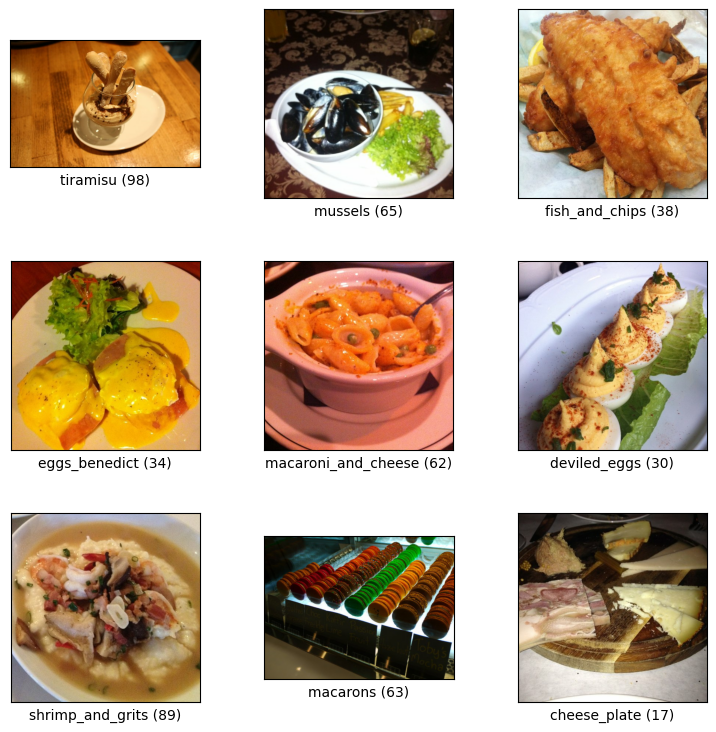

In [ ]:
# here we can run this cell to see what images exist in the training dataset, if you run it couple of times you might see HOT DOG!
fig = tfds.show_examples(train_ds,ds_info)

In [ ]:
#resizing the imges to make them of same size
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
#here i am gonna take  training dataset and apply map function to each image to resize to new  size
#here we are gonna apply lambda to each image and label associated with it, we will keep the label as== 1 if image is hot dog else 0 & using tensorflow image resize, change the size to above defined size
#also you might get warning about the type of data passed to the tensorflow therefore, we will type cast it to int
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
#applying the above processing steps to the validation step too

validate_ds = validate_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

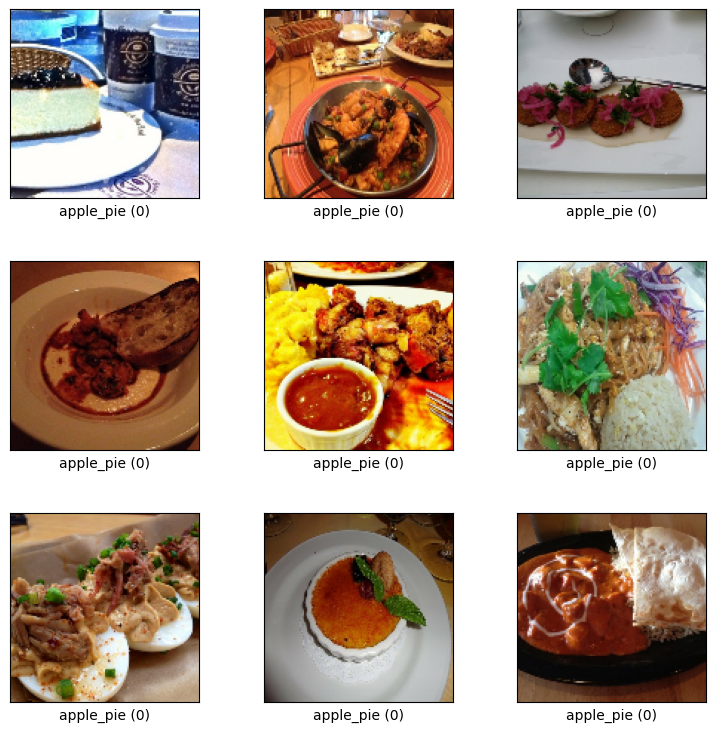

In [ ]:
#verifying if above processing worked
fig = tfds.show_examples(train_ds,ds_info)

In [ ]:
#NOTE: above you can see everything says apple pie even thoug it is not, it is just it is labelling anything which is not hot dog as apple pie and defaul label for hot dog as baby back ribs

In [ ]:
# now we will proceed to balance our dataset, in our dataset there are 750 images of each food type, thus it suffers from the dataset imbalance problem, as there are only 750 images of hot dog
train_hd_size, validate_hd_size = 750,250 #from the documentation we know there are only 750 images of hot dog in trianing data and 250 in validation set

train_hotdogs = train_ds.filter(lambda image,label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image,label: label == 0)

In [ ]:
valid_hotdogs = validate_ds.filter(lambda image,label: label == 1).repeat(3)
valid_nothotdogs = validate_ds.filter(lambda image,label: label == 0)

In [ ]:
# again even though we upsampled the is hot dog data 3 times, still the not hot dog is way bigger therefore we will take 50% data from each class and construct a new balanced dataset
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs,trian_nothotdogs],
                                                [0.5,0.5],
                                                stop_on_empty_dataset= True)

train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
#cache: storing data in some local storage to save some time for each cycle of training
# batch_size: passing 16 images at same time during training rathe than one image
#prefetch: to save some time, while model is training some step a model already read images for step s+1

validate_ds = tf.data.Dataset.sample_from_datasets([validate_hotdogs,validate_nothotdogs],
                                                   [0.5,0.5],
                                                   stop_on_empty_dataset= True)

validate_ds = validate_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
for image_batch,label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[226 226 177]
   [228 228 175]
   [224 226 170]
   ...
   [241 239 199]
   [240 233 200]
   [233 236 205]]

  [[220 221 162]
   [220 220 168]
   [218 219 162]
   ...
   [235 239 196]
   [240 236 201]
   [235 237 206]]

  [[214 216 156]
   [212 210 169]
   [211 210 161]
   ...
   [234 239 199]
   [239 237 206]
   [234 234 206]]

  ...

  [[132 115  72]
   [126 112  70]
   [167 159 117]
   ...
   [241 242 226]
   [242 243 227]
   [242 243 227]]

  [[129 110  70]
   [126 107  66]
   [133 119  76]
   ...
   [243 244 226]
   [243 244 226]
   [243 244 226]]

  [[134 112  75]
   [126 102  64]
   [124 106  66]
   ...
   [245 247 226]
   [243 245 224]
   [240 242 221]]]


 [[[  1   1   3]
   [  1   1   3]
   [  1   1   3]
   ...
   [ 10  10  10]
   [  5   5   5]
   [  2   2   2]]

  [[  1   1   3]
   [  1   1   3]
   [  1   1   3]
   ...
   [  4   4   4]
   [  1   1   1]
   [  1   1   1]]

  [[  1   1   3]
   [  0   0   2]
   [  0   0   2]
   ...
   [  3   3   3]
   [  1   1   1]


 # STARTING NEURAL NETWORK IMPLEMENTATION HERE

In [ ]:
#seeding this to recreate it in futureee
random.seed(0)
model = models.Sequential()

#building CNN here
model.add(layers.Rescaling(1./255 )) #rescaling the colors from 1 to 255 to number between 0 and 1
model.add(layers.Conv2D(128,(3,3),activation = 'relu',input_shape = [MAX_SIDE_LEN,MAX_SIDE_LEN,3])) # 3 here is beacuse we have 3 colors
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten()) # adding flattening laye to get from convolutional to the fully connected we use flatten layer
model.add(layers.Dense(128,activation = 'relu'))
model.add(layers.Dense(1)) #as output is binary thus only one layer


In [ ]:
#starting to train out model
lr = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), #to let our loss function know that output is not projected from 0 to 1 read more abt it look sintersting
              metrics = ['accuracy'])

In [ ]:
epochs = 50
history = model.fit(train_ds,
                    epochs = epochs,
                    validation_data = validate_ds,
                    verbose = 1 )# to see things running


Epoch 1/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 887s 3s/step - accuracy: 0.5010 - loss: 0.6936 - val_accuracy: 0.5480 - val_loss: 0.6396
Epoch 2/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.5900 - loss: 0.6414 - val_accuracy: 0.6128 - val_loss: 0.6106
Epoch 3/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.6788 - loss: 0.5691 - val_accuracy: 0.6485 - val_loss: 0.6098
Epoch 4/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.7455 - loss: 0.4934 - val_accuracy: 0.6407 - val_loss: 0.6635
Epoch 5/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.7930 - loss: 0.4216 - val_accuracy: 0.6576 - val_loss: 0.7324
Epoch 6/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.8388 - loss: 0.3447 - val_accuracy: 0.6628 - val_loss: 0.8493
Epoch 7/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.8846 - loss: 0.2598 - val_accuracy: 0.6621 - val_loss: 0.9516
Epoch 8/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.9383 - loss: 0.1805 - val_accu

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in validate_ds.take(1):
  images = image_batch
  labels = label_batch


<Figure size 1000x1000 with 0 Axes>